**Summary**

Environment, Social and Corporate Governance (ESG) refers to the three central factors in measuring the sustainability and societal impact of an investment in a company or business. These criteria help to better determin the future financial performance of companies (return and risk).

This analysis extracts text from a ESG report in PDF format from the internet, performs NLP on these information, summaries the key ESG initiatives with WordClouds, TDIDFs and discovers topics by building a Latent Dirichlet Allocation (LDA) model.

To keep this exercise as simple as possible, only one ESG report is being used. Specifically the Morgan Stanley 2020 sustainability report.
Given that ESG is a broad topic. Different companies focus on different aspects of ESG depending on their business operations and culture. One can potentially ingest more ESG reports from different companies across all sectors and industries to capture relevant ESG topics.

**This serves the surpose of the current MSc Project.**

This study can be extended to more reports issued by the many companies across different sectors and industries.
We can expect the number of topics to increase when more ESG reports are included in the study.
Once relevant ESG topics are identified, then we can potentially calculate ESG scores by topics for all companies. Then we can assess and see whether such ESG score derived through NLP process correlates with the score given by rating agencies downloaded from yahoo finance.

**Installing the Dependencies**

In [ ]:
pip install PyPDF2

In [2]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install WordCloud

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pdfminer

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install pyLDAvis==2.1.2

Note: you may need to restart the kernel to use updated packages.


**Installing Dependencies:**

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import pandas as pd
import numpy as np

# pd.options.display.max_columns = 50
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 50)

plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

In [11]:
import sys 
sys.path.append('/home/levente/Desktop/project/morganstanley')
from filelist import *

In [12]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# PDF text extraction
from pdfminer3.layout import LAParams, LTTextBox
from pdfminer3.pdfpage import PDFPage
from pdfminer3.pdfinterp import PDFResourceManager
from pdfminer3.pdfinterp import PDFPageInterpreter
from pdfminer3.converter import PDFPageAggregator
from pdfminer3.converter import TextConverter

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# Others
import requests
import io
import string
import re
from pprint import pprint
from tqdm.notebook import tqdm
import io

**Creating the Folders**

In [13]:
DATA_FOLDER = '/home/levente/Desktop/project/morganstanley/data'
PDF_FOLDER = '/home/levente/Desktop/project/morganstanley/pdf'
createfolder(DATA_FOLDER)
createfolder(PDF_FOLDER)

**Loading Language Model**

In [14]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

import spacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm", disable=['ner'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


**Preparing StopWords**

In [15]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn.feature_extraction import text
stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)

In [16]:
', '.join(stop_words)

"also, that'll, hasn't, below, needn't, three, much, name, couldnt, cant, sometime, whole, every, five, on, were, hasnt, afterwards, thick, done, amongst, however, show, another, their, your, forty, because, of, whether, nevertheless, full, d, etc, please, whom, although, towards, some, beforehand, throughout, whither, through, elsewhere, almost, least, sixty, and, detail, beside, seems, since, first, you'd, namely, her, might, nowhere, they, whereby, third, until, neither, out, now, rather, along, won't, nothing, from, re, are, six, at, eg, hereupon, others, onto, why, latterly, again, there, ve, won, fifteen, has, even, t, empty, become, didn't, behind, therein, couldn, any, be, being, ten, ourselves, latter, not, enough, we, his, eleven, already, get, a, other, upon, shan't, seeming, still, then, became, him, next, than, hence, may, would, about, ever, around, wherein, which, hadn, our, many, shan, for, whence, serious, it's, without, moreover, mill, herein, everywhere, seemed, wher

**Report Details**
This Report is in PDF format and downloadable from a URL.

1. Company Name
2. Company Ticker Symbol (obtained from the NYSE website)
3. Year of the Report
4. URL of the Report

In [17]:
report_company = 'Morgan Stanley'
report_ticker = 'MS'
report_year = '2020'
report_url = 'https://www.morganstanley.com/pub/content/dam/msdotcom/sustainability/Morgan-Stanley_2020-Sustainability-Report_Final.pdf'

Additional information - ESG Score from Yahoo Finance.
Extracting using Yfinance a python package. 

In [18]:
import yfinance as yf
import pandas as pd

ticker_info = yf.Ticker(report_ticker)
esg_data = pd.DataFrame(ticker_info.sustainability)
esg_data.columns = [str(ticker_info.ticker)]

esg_data.loc[['totalEsg','socialScore','governanceScore','environmentScore',
              'esgPerformance','percentile','peerGroup','highestControversy'],:]

,MS
2021-5,
totalEsg,22.68
socialScore,12.47
governanceScore,9.4
environmentScore,0.81
esgPerformance,AVG_PERF
percentile,30.8
peerGroup,Diversified Financials
highestControversy,3


**Text Extraction**

Extract information from the PDF report.

In [19]:
def extract_pdf(file, verbose=False):
    
    if verbose:
        print('Processing {}'.format(file))

    try:
        resource_manager = PDFResourceManager()
        fake_file_handle = io.StringIO()
        codec = 'utf-8'
        laparams = LAParams()

        converter = TextConverter(resource_manager, fake_file_handle, codec=codec, laparams=laparams)
        page_interpreter = PDFPageInterpreter(resource_manager, converter)
        
        password = ""
        maxpages = 0
        caching = True
        pagenos = set()

        content = []

        for page in PDFPage.get_pages(file,
                                      pagenos, 
                                      maxpages=maxpages,
                                      password=password,
                                      caching=True,
                                      check_extractable=False):

            page_interpreter.process_page(page)

            content.append(fake_file_handle.getvalue())

            fake_file_handle.truncate(0)
            fake_file_handle.seek(0)        

        text = '##PAGE_BREAK##'.join(content)

        # close open handles
        converter.close()
        fake_file_handle.close()
        
        return text

    except Exception as e:
        print(e)

        # close open handles
        converter.close()
        fake_file_handle.close()

        return ""

In [20]:
def extract_content(url):
    """
    A simple user define function that, given a url, download PDF text content
    Parse PDF and return plain text version
    """
    headers={"User-Agent":"Mozilla/5.0"}

    try:
        # retrieve PDF binary stream
        r = requests.get(url, allow_redirects=True, headers=headers)
        
        # access pdf content
        text = extract_pdf(io.BytesIO(r.content))

        # return concatenated content
        return text

    except:
        return ""

In [21]:
report_content = extract_content(report_url)

**Saving to a json file.**

In [22]:
import json

In [23]:
report = {'company':report_company, 'year':report_year, 'ticker':report_ticker, 
          'url':report_url, 'content':report_content}

with open(DATA_FOLDER + report_company+report_year+'.json', "w") as outfile:  
    json.dump(report, outfile)

**To re-load json if required**

In [24]:
with open(DATA_FOLDER + 'Morgan Stanley2020.json') as inputfile:
     report = json.load(inputfile)

**Natural Language Processing**

**Extracting content by pages and sentences**

1. Only properly structured sentences are extracted. Sentences that start with a Capital Letter and ends with a period. Sentences that are less than 10 words or more than 50 words are ignored.
2. Pages with less than 500 words are excluded from extraction. Would like to focus on pages with mostly text content. This should exclude pages like cover and last page. It should also exclude pages that are more graphical with short notes and comments.

In [25]:
def remove_non_ascii(text):
    printable = set(string.printable)
    return ''.join(filter(lambda x: x in printable, text))

def not_header(line):
    # as we're consolidating broken lines into paragraphs, we want to make sure not to include headers
    return not line.isupper()

def extract_sentences(nlp, text):
    """
    Extracting ESG statements from raw text by removing junk, URLs, etc.
    We group consecutive lines into paragraphs and use spacy to parse sentences.
    """
    MIN_WORDS_PER_PAGE = 500
    
    pages = text.split('##PAGE_BREAK##')
#     print('Number of Pages: {}'.format(len(pages)))

    lines = []
    for page in pages:
        
        # remove non ASCII characters
        text = remove_non_ascii(page)
        
        if len(text.split(' ')) < MIN_WORDS_PER_PAGE:
#             print('Skipped Page: {}'.format(len(text.split(' '))))
            continue
        
        prev = ""
        for line in text.split('\n\n'):
            # aggregate consecutive lines where text may be broken down
            # only if next line starts with a space or previous does not end with dot.
            if(line.startswith(' ') or not prev.endswith('.')):
                prev = prev + ' ' + line
            else:
                # new paragraph
                lines.append(prev)
                prev = line

        # don't forget left-over paragraph
        lines.append(prev)
        lines.append('##SAME_PAGE##')
        
    lines = '  '.join(lines).split('##SAME_PAGE##')
    
    # clean paragraphs from extra space, unwanted characters, urls, etc.
    # best effort clean up, consider a more versatile cleaner
    
    sentences = []
    pages_content = []

    for line in lines[:-1]:
        # removing header number
        line = re.sub(r'^\s?\d+(.*)$', r'\1', line)
        # removing trailing spaces
        line = line.strip()
        # words may be split between lines, ensure we link them back together
        line = re.sub(r'\s?-\s?', '-', line)
        # remove space prior to punctuation
        line = re.sub(r'\s?([,:;\.])', r'\1', line)
        # ESG contains a lot of figures that are not relevant to grammatical structure
        line = re.sub(r'\d{5,}', r' ', line)
        # remove emails
        line = re.sub(r'\S*@\S*\s?', '', line)
        # remove mentions of URLs
        line = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', r' ', line)
        # remove multiple spaces
        line = re.sub(r'\s+', ' ', line)
        # join next line with space
        line = re.sub(r' \n', ' ', line)
        line = re.sub(r'.\n', '. ', line)
        line = re.sub(r'\x0c', ' ', line)
        
        pages_content.append(str(line).strip())

        # split paragraphs into well defined sentences using spacy
        for part in list(nlp(line).sents):
            sentences.append(str(part).strip())

#           sentences += nltk.sent_tokenize(line)
            
    # Only interested in full sentences and sentences with 10 to 100 words.
    sentences = [s for s in sentences if re.match('^[A-Z][^?!.]*[?.!]$', s) is not None]
    sentences = [s.replace('\n', ' ') for s in sentences]
    sentences = [s for s in sentences if (len(s.split(' ')) > 10) & (len(s.split(' ')) < 100)]

    return pages_content, sentences

In [26]:
report_pages, report_sentences = extract_sentences(nlp, report['content'])

**We can remove headers**

In [27]:
headers = ['2020 SUSTAINABILITY  REPORT']

for header in headers:
    report_pages = [p.replace(header, "").strip() for p in report_pages]
    report_sentences = [p.replace(header, "").strip() for p in report_sentences]

**Tokenization, Bigrams and Lemmatization**

In [28]:
def run_NLP(content):

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

    # Define functions for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    data_words = list(sent_to_words(content))

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    return data_lemmatized

**Using full text content in a page rather than full text content in a sentence here. A page defined as a document as per TFIDF calculation.**

In [29]:
data_lemmatized = run_NLP(report_pages)

In [30]:
report_sentences_lemma = [' '.join(w) for w in data_lemmatized]

In [31]:
import random
report_sentences_lemma[random.randint(0, len(report_sentences_lemma))]

'return workplace task force develop phase strategy guide follow principle health safety employee remain priority guide decision sensitivity individual need concern individual return office comfortable particular sensitivity show increase risk live increase risk child care eld care issue medical public health guidance decision time create safe condition return base medical public health evidence datum guideline include meeting requirement distance office set provision personal protective equipment local office business unit office world face different local issue condition ground business unit different need requirement return work decision factor account overall guideline transparency flexibility commit transparency frequent communication people fully inform ready return work adapt highly fluid condition grind revise phase return office need environmental social risk management commitment stakeholder community environment identify manage environmental social risk environmental social 

**Relevant sentences are now well defined for ESG corpus.**

**Word Cloud - Corpus Wide Term Frequencies**

In [32]:
# context specific keywords not to include in topic modelling
esg_stop_words = [
  'plc', 'group', 'target',
  'track', 'capital', 'holding',
  'report', 'annualreport',
  'esg', 'bank', 'report',
  'annualreport', 'long', 'make'
]

esg_stop_words.append('report_company')
esg_stop_words.append('MORGAN STANLEY')

# our list contains all english stop words + companies names + specific keywords
stop_words = stop_words.union(esg_stop_words)

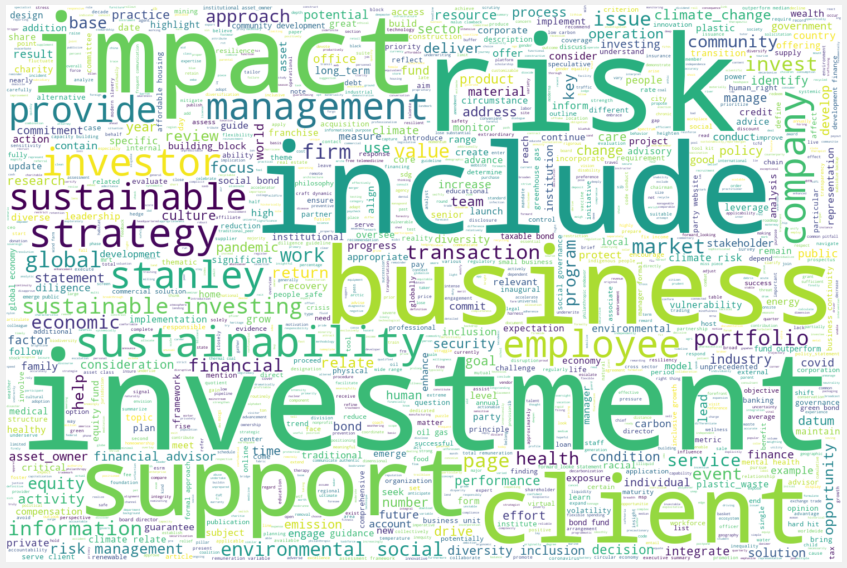

In [33]:
from wordcloud import WordCloud

# aggregate all 7200 records into one large string to run wordcloud on term frequency
large_string = ' '.join(report_sentences_lemma)

# use 3rd party lib to compute term freq., apply stop words
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=1500, 
    height=1000, 
    stopwords=stop_words, 
    contour_width=3, 
    contour_color='steelblue'
)

# display our wordcloud across all records
plt.figure(figsize=(16,16))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**TFIDF - Unigram and Bigram Analysis**

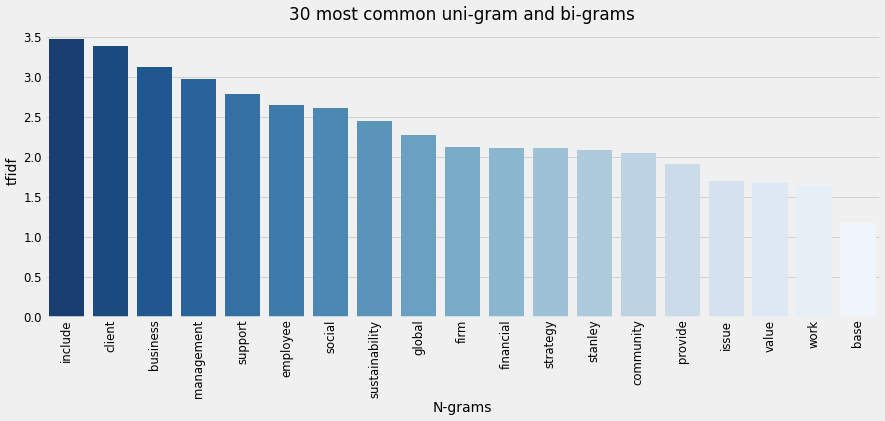

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=10, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(report_sentences_lemma)

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

# Plot top 10 ngrams
plt.figure(figsize=(16, 6))
plt.subplot(title='30 most common uni-gram and bi-grams')
sns.barplot(x_pos, counts, palette='Blues_r')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('N-grams')
plt.ylabel('tfidf')
plt.show()

**Topic Modeling and Latent Dirichlet Allocation (LDA)**

**Evaluaton Metrics**

**Perplexity: Captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set. Lower the better.
Coherence Score: Measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. Higher the better.
In the analysis, the model with the highest coherence score is selected as the optimal model.**

In [35]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [36]:
results = []
optimal_score = 0
optimal_model = None

for num_of_topics in tqdm(range(2,15,1)):
    
    result = {}
    
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_of_topics, 
                                                random_state=42,
                                                update_every=1,
                                                chunksize=5,
                                                passes=20,
                                                alpha='auto',
                                                per_word_topics=True) 

    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    if optimal_score < coherence_model_lda.get_coherence():
        optimal_score = coherence_model_lda.get_coherence()
        optimal_model = lda_model

    result['num_of_topics'] = num_of_topics
    result['perplexity'] = lda_model.log_perplexity(corpus)
    result['coherence_score'] = coherence_model_lda.get_coherence()
    
    results.append(result)
    
results = pd.DataFrame(results)  
results.set_index('num_of_topics', inplace=True)

  0%|          | 0/13 [00:00<?, ?it/s]

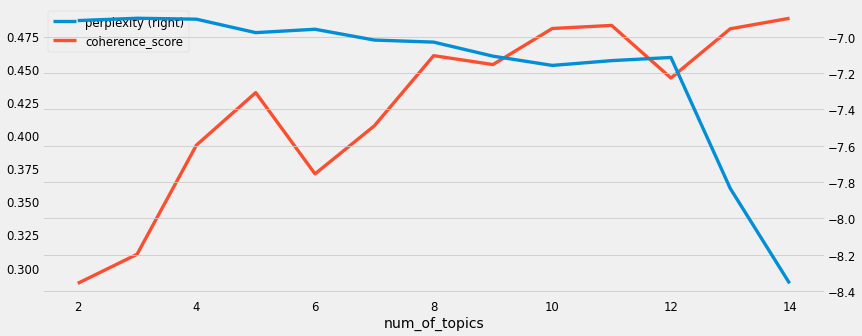

In [37]:
results.plot(secondary_y='perplexity')
plt.show()

In [38]:
results

,perplexity,coherence_score
num_of_topics,,
2,-6.912046,0.288058
3,-6.899320,0.310020
4,-6.904323,0.392421
5,-6.978387,0.432146
6,-6.959767,0.370745
7,-7.019193,0.407052
8,-7.030581,0.460063
9,-7.107861,0.453334
10,-7.158728,0.480590


In [39]:
# Compute Perplexity
print('\nPerplexity of the Optimal Model: ', optimal_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score of the Optimal Model: ', coherence_lda)


Perplexity of the Optimal Model:  -8.357858794959947

Coherence Score of the Optimal Model:  0.4883135112237456


**Visualize the topics**

In [41]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.260716 -0.187489       1        1  58.074693
2     -0.098083 -0.298117       2        1  23.611708
6      0.180774  0.240666       3        1  15.887981
12    -0.097055  0.087383       4        1   1.358713
3     -0.088343  0.006293       5        1   1.005253
7     -0.018775  0.014289       6        1   0.043108
13    -0.017404  0.017122       7        1   0.002392
5     -0.017404  0.017122       8        1   0.002316
1     -0.017404  0.017122       9        1   0.002316
0     -0.017404  0.017122      10        1   0.002315
10    -0.017404  0.017122      11        1   0.002312
9     -0.017404  0.017122      12        1   0.002299
4     -0.017404  0.017122      13        1   0.002298
8     -0.017404  0.017122      14        1   0.002295, topic_info=             Term       Freq      Total Category  logprob  loglift
287    investment  88.000000  88.000000  Default   30.000  30.0000
180   sustainable  59.000000  59.000000  Default   29.000  29.0000
288      investor  43.000000  43.000000  Default   28.000  28.0000
173      strategy  39.000000  39.000000  Default   27.000  27.0000
109     investing  39.000000  39.000000  Default   26.000  26.0000
...           ...        ...        ...      ...      ...      ...
1041       unable   0.000087   0.284620  Topic14   -7.346   2.5926
1042     underlie   0.000087   0.289745  Topic14   -7.346   2.5748
1063      balance   0.000087   0.285275  Topic14   -7.346   2.5903
1062   background   0.000087   0.285275  Topic14   -7.346   2.5903
1061     ambition   0.000087   0.285275  Topic14   -7.346   2.5903

[805 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         2  0.886841      ability
1         5  1.193040   accelerate
3         3  0.628127  acquisition
3         5  0.314064  acquisition
204       1  0.137002     activity
...     ...       ...          ...
194       2  0.111778        value
1368      3  1.037861     variable
197       1  0.080902         work
197       2  0.647219         work
197       3  0.283158         work

[234 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 3, 7, 13, 4, 8, 14, 6, 2, 1, 11, 10, 5, 9])

In [42]:
# Print the Keyword in the 10 topics
pprint(optimal_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.001*"tourism" + 0.001*"traditional_peer" + 0.001*"taxable" + 0.001*"term" '
  '+ 0.001*"thought" + 0.001*"systematic" + 0.001*"turbulent" + '
  '0.001*"trigger" + 0.001*"system" + 0.001*"transition"'),
 (1,
  '0.001*"tourism" + 0.001*"traditional_peer" + 0.001*"taxable" + 0.001*"term" '
  '+ 0.001*"thought" + 0.001*"systematic" + 0.001*"turbulent" + '
  '0.001*"trigger" + 0.001*"system" + 0.001*"transition"'),
 (2,
  '0.027*"business" + 0.025*"management" + 0.024*"employee" + 0.022*"risk" + '
  '0.019*"health" + 0.018*"include" + 0.014*"support" + 0.012*"program" + '
  '0.012*"people" + 0.011*"work"'),
 (3,
  '0.014*"acquisition" + 0.010*"thing" + 0.010*"close" + 0.010*"accelerate" + '
  '0.010*"strength" + 0.005*"lie" + 0.005*"hopeful" + 0.005*"historically" + '
  '0.005*"front" + 0.005*"humanitarian"'),
 (4,
  '0.001*"tourism" + 0.001*"traditional_peer" + 0.001*"taxable" + 0.001*"term" '
  '+ 0.001*"thought" + 0.001*"systematic" + 0.001*"turbulent" + '
  '0.001*"trigger" + 

**Distinguishing the different ESG topics**

In [45]:
topic_names = {0: 'ethical investments', 1: 'support community'}

#     'value employees',
#     'ethical investments',
#     'strong governance',
#     'focus customer',    
#     'green energy',
#     'support community',
#     'code of conduct',
#     'sustainable finance',
#     'company transformation',

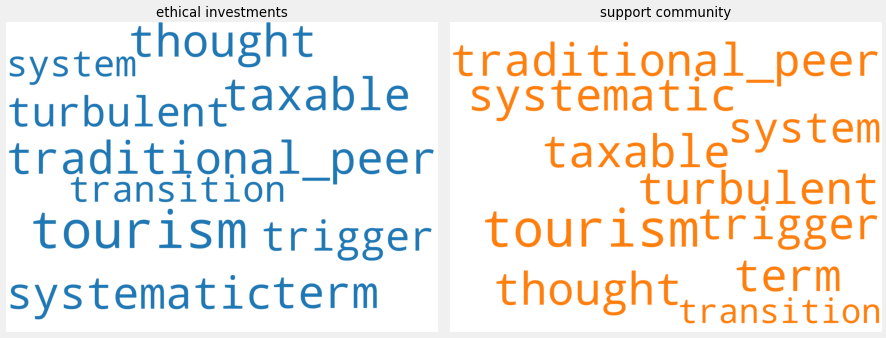

/root/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/root/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/root/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/root/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [46]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(topic_names[i], fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()